In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.tseries.offsets import DateOffset
import seaborn as sns
import matplotlib.pyplot as plt 
import math 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# geopy is a Python client for several popular geocoding web services.
# geopy makes it easy for Python developers to locate the coordinates of addresses, cities, countries, 
# and landmarks across the globe using third-party geocoders and other data sources.
# https://pypi.org/project/geopy/
from geopy import distance
from geopy.geocoders import Nominatim
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
# models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading the Dataset

In [2]:
uber = pd.read_csv('uber.csv')

uber.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


# Data info

In [3]:
uber.info()
uber.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                199999 non-null  int64  
 1   date               199999 non-null  object 
 2   fare_amount        199999 non-null  float64
 3   pickup_datetime    199999 non-null  object 
 4   pickup_longitude   199999 non-null  float64
 5   pickup_latitude    199999 non-null  float64
 6   dropoff_longitude  199998 non-null  float64
 7   dropoff_latitude   199998 non-null  float64
 8   passenger_count    199999 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')


# Dropping the NULL values

In [4]:
uber.columns =['Unumber', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count']
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unumber            199999 non-null  int64  
 1   key                199999 non-null  object 
 2   fare_amount        199999 non-null  float64
 3   pickup_datetime    199999 non-null  object 
 4   pickup_longitude   199999 non-null  float64
 5   pickup_latitude    199999 non-null  float64
 6   dropoff_longitude  199998 non-null  float64
 7   dropoff_latitude   199998 non-null  float64
 8   passenger_count    199999 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


# Split Train Test

In [16]:
X_train, X_test = train_test_split(uber, test_size=0.3, random_state=41236)
X_train.head() 


,Unumber,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
129546,4264204,2013-10-11 20:42:00.000000209,13.50,2013-10-11 20:42:00 UTC,-73.968367,40.755280,-74.000925,40.731782,1
157708,16914374,2009-05-22 22:56:00.000000207,28.25,2009-05-22 22:56:00 UTC,-73.871200,40.773960,-73.996203,40.759870,1
146825,274789,2011-02-28 06:56:44.0000002,6.90,2011-02-28 06:56:44 UTC,-73.996791,40.737605,-73.977832,40.763559,1
192482,11942062,2015-01-04 17:04:31.0000004,39.33,2015-01-04 17:04:31 UTC,-73.873100,40.774040,-73.985306,40.732552,1
187756,42996243,2014-04-27 12:59:00.000000182,14.50,2014-04-27 12:59:00 UTC,-73.956453,40.771052,-73.991773,40.749097,1


# Transformers

# Retio

In [9]:
class RetioTransformer(BaseEstimator, TransformerMixin):
   #######
    def __init__(self, multi=1):
        self.multi = multi
        self.std_dev = 0
           
    def get_std_dev(self, X, col_name='retio'):
        # calculate the standard deviation of the data in the specified column 
        std_dev = X[col_name].std() # return the standard deviation 
        self.std_dev =  std_dev * self.multi
        print(f'std dev = {self.std_dev}')
    
    def fit(self, X):
        self.get_std_dev(X, 'retio')
        
    def transform(self, X):
        X.drop(X[(X['distance']/X['fare_amount']) >=self.std_dev].index, inplace = True)
        X.drop(X[(X['distance']/X['fare_amount']) <(self.std_dev/100)].index, inplace = True)
        return X
        
        

# Clean Data
**Clean data where longitude and latitude >90 or <-90 or ==0  or null values**
**fare_amount >500 or fare_amount <0**

In [8]:
class CleaningTransformer(BaseEstimator, TransformerMixin):
   #######
    def __init__(self):
        pass

    def fit(self, X):  # 
        return self
    
    
    def clean_data(self, df):
        try: 
            df['pickup_longitude'] = df['pickup_longitude'].replace(np.nan, 0)
            df['pickup_latitude'] = df['pickup_latitude'].replace(np.nan, 0)
            df['dropoff_longitude'] = df['dropoff_longitude'].replace(np.nan, 0)
            df['dropoff_latitude'] = df['dropoff_latitude'].replace(np.nan, 0)
            
            df.drop(df[df['pickup_longitude']==0].index, inplace = True)
            df.drop(df[df['pickup_latitude']==0].index, inplace = True)
            df.drop(df[df['dropoff_longitude']==0].index, inplace = True)
            df.drop(df[df['dropoff_latitude']==0].index, inplace = True)

            df.drop(df[df['dropoff_latitude']>90].index, inplace = True)
            df.drop(df[df['dropoff_latitude']<-90].index, inplace = True)
            #
            df.drop(df[df['dropoff_longitude']>90].index, inplace = True)
            df.drop(df[df['dropoff_longitude']<-90].index, inplace = True)
            #
            df.drop(df[df['pickup_longitude']>90].index, inplace = True)
            df.drop(df[df['pickup_longitude']<-90].index, inplace = True)
            #
            df.drop(df[df['pickup_latitude']>90].index, inplace = True)
            df.drop(df[df['pickup_latitude']<-90].index, inplace = True)
            
            df.drop(df[df['passenger_count']>10].index, inplace = True)

            df.drop(df[df['fare_amount']<=0].index, inplace = True)
            df.drop(df[df['fare_amount']>500].index, inplace = True)
            
            print('Cleaned successfully')
        except Exception as ex:
            print(ex)

        return df
    
    def transform(self, X):
        X = self.clean_data(X)
        return X

 # Add date attributes 

In [10]:
class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X):
        return self
    
    def add_date_attributes(self, df):
        try:
            df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
            df['year'] = pd.DatetimeIndex(df['pickup_datetime']).year
            df['month'] = pd.DatetimeIndex(df['pickup_datetime']).month
            df['day'] = pd.DatetimeIndex(df['pickup_datetime']).day
            df['hour'] = pd.DatetimeIndex(df['pickup_datetime']).hour
            df['weekday'] = pd.DatetimeIndex(df['pickup_datetime']).weekday
            df['day_name'] = pd.DatetimeIndex(df['pickup_datetime']).day_name()

            df['day_part'] = pd.cut(df['hour'],[-1,6,16,25] , labels=['2','1', '3'] )
            df['day_part']=df['day_part'].str.replace('3', '2')
            df['season']=pd.cut(df['month'], [0 ,3,9 ,13] , labels=['1','2', '0'] )
            df['season']=df['season'].str.replace('0', '1')
            df['weekend']=pd.cut(df['weekday'], [-1,4,6] , labels=['1','2'] )
            
            df['year_2009']=np.where(df['year']==2009 ,1,0)
            df['year_2010']=np.where(df['year']==2010 ,1,0)
            df['year_2011']=np.where(df['year']==2011 ,1,0)
            df['year_2012']=np.where(df['year']==2012 ,1,0)
            df['year_2013']=np.where(df['year']==2013 ,1,0)
            df['year_2014']=np.where(df['year']==2014 ,1,0)
            df['year_2015']=np.where(df['year']==2015 ,1,0)
            
            df['retio']= df['distance']/df['fare_amount']                     
            
            print('Date attributes add successfully')
        except Exception as ex:
            print(ex)
        
        return df
    
    def transform(self, X):
        X = self.add_date_attributes(X)
        return X

# Add distance between geo points

In [11]:
class GeoTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X):  # 
        return self
   
    def add_distance(self, X):
        X = X.reset_index()
        l_distance = []
        for index, row in X.iterrows():
            pickup = (row['pickup_longitude'], row['pickup_latitude'])
            dropoff= (row['dropoff_longitude'],row['dropoff_latitude'])
            try:
                dis = distance.distance(pickup, dropoff).km
            except Exception as ex:
                print(f'Row {row["Unumber"]}. ERROR: {ex}')
                dis = -1
            l_distance.append( dis)
        X['distance'] = pd.Series(l_distance)
        
        X.drop(X[X['distance']==-1].index, inplace = True)
        X.drop(X[X['distance']>100].index, inplace = True)

        return X

    def transform(self, X):
        X = self.add_distance(X)
        X['distance_range']=pd.cut(X['distance'], [0,1,2,3,4,8,10000] , labels=['1','2', '3','4','8','10000'] )
        print('Distance attributes add successfully')
        return X

# Dummy Replace values to dummies (get_dummies)

In [12]:
class DummyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self):
         return self
    
    def dummy(self, df):
        df=df[['fare_amount','passenger_count','hour','weekday','distance','day_part','season','weekend','distance_range','year_2009','year_2010','year_2011','year_2012','year_2013','year_2014','year_2015']]
        df=pd.get_dummies(df,columns = ['passenger_count', 'hour','day_part','season','weekend','distance_range'])
        #  df[year_2009]= df.iloc[df['year']==2009]
        return df
    
    def transform(self, X):
        X = self.dummy(X)
        print('Get Dummies successfully')
        return X

# Address

In [13]:
class AddressTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X):  #
        X['pickup_coordinates']= X['pickup_latitude'].astype(str)+','+X['pickup_longitude'].astype(str)
        X['dropoff_coordinates']= X['dropoff_latitude'].astype(str)+','+X['dropoff_longitude'].astype(str)
        return X

    def get_address(coord):
        geolocator = Nominatim(user_agent="David K")
        try:
            location=geolocator.reverse(coord).address
        except Exception as ex:
            print(f'Row in {coord} ERROR: {ex}')
            location ='no address'   
        return location 
    
    def transform(self, X):
        X['pickup_address'] = X['pickup_coordinates'].apply(get_address)
        X['dropoff_address'] = X['dropoff_coordinates'].apply(get_address)
        
        return X
    

# Add degrees function

In [14]:
import math
class Add_degreesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X):  #
        return X
    
    def degrees_to_dms(self, dec_degrees):
        degrees = math.trunc(dec_degrees)
        minutes = math.trunc((dec_degrees - degrees) * 60)
        seconds = (((dec_degrees - degrees) * 60) - minutes) * 60
       
        return degrees, minutes, seconds
    
    def transform(self, X):
        X['pickup_lon_degrees'] = X['pickup_longitude'].apply(self.degrees_to_dms)
        X['pickup_lat_degrees'] = X['pickup_latitude'].apply(self.degrees_to_dms)
        X['dropoff_lon_degrees'] = X['dropoff_longitude'].apply(self.degrees_to_dms)
        X['dropoff_lat_degrees'] = X['dropoff_latitude'].apply(self.degrees_to_dms)
        print('Degrees added successfully')
        
        return X


# X Train

In [17]:
# Clean 
X_train = CleaningTransformer().transform(X_train)


Cleaned successfully


In [18]:
# Distance 
X_train = GeoTransformer().transform(X_train)

Distance attributes add successfully


In [22]:
X_train

,index,Unumber,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,distance_range
0,129546,4264204,2013-10-11 20:42:00.000000209,13.50,2013-10-11 20:42:00 UTC,-73.968367,40.755280,-74.000925,40.731782,1,3.705146,4
1,157708,16914374,2009-05-22 22:56:00.000000207,28.25,2009-05-22 22:56:00 UTC,-73.871200,40.773960,-73.996203,40.759870,1,13.958072,10000
2,146825,274789,2011-02-28 06:56:44.0000002,6.90,2011-02-28 06:56:44 UTC,-73.996791,40.737605,-73.977832,40.763559,1,2.261968,3
3,192482,11942062,2015-01-04 17:04:31.0000004,39.33,2015-01-04 17:04:31 UTC,-73.873100,40.774040,-73.985306,40.732552,1,12.588475,10000
4,187756,42996243,2014-04-27 12:59:00.000000182,14.50,2014-04-27 12:59:00 UTC,-73.956453,40.771052,-73.991773,40.749097,1,3.999675,4
...,...,...,...,...,...,...,...,...,...,...,...,...
137179,104655,12368926,2014-12-09 22:40:00.000000217,15.00,2014-12-09 22:40:00 UTC,-74.007737,40.704722,-73.970580,40.751642,1,4.391599,8
137180,145424,625653,2009-02-26 15:00:58.0000004,6.10,2009-02-26 15:00:58 UTC,-73.968899,40.763346,-73.977598,40.753115,1,1.020828,2
137181,198481,12697687,2014-05-21 10:51:18.0000008,14.50,2014-05-21 10:51:18 UTC,-73.987548,40.718471,-74.013865,40.709392,4,2.950456,3
137182,141750,52690186,2010-05-20 20:20:00.00000094,4.90,2010-05-20 20:20:00 UTC,-73.968810,40.767775,-73.955563,40.768348,1,1.478575,2


In [23]:
X_train.to_csv('UberEdited.csv')


,index,Unumber,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,137167.000000,1.371670e+05,137167.000000,137167.000000,137167.000000,137167.000000,137167.000000,137167.000000,137167.000000
mean,99982.363878,2.771385e+07,11.326699,-73.908494,40.687468,-73.907614,40.687791,1.685610,2.720235
std,57693.702144,1.602213e+07,9.761411,2.716096,2.652930,2.716191,2.653291,1.308429,3.947242
min,1.000000,3.350000e+02,0.110000,-75.387785,-74.015515,-75.417737,-74.009857,0.000000,0.000000
25%,50082.500000,1.380899e+07,6.000000,-73.992257,40.736488,-73.991620,40.735324,1.000000,0.859400
50%,100079.000000,2.774255e+07,8.500000,-73.982085,40.753345,-73.980522,40.753763,1.000000,1.559622
75%,149918.500000,4.155250e+07,12.500000,-73.968315,40.767505,-73.965341,40.768358,2.000000,2.846604
max,199999.000000,5.542357e+07,499.000000,40.808425,45.031653,40.831932,45.031598,6.000000,99.092369


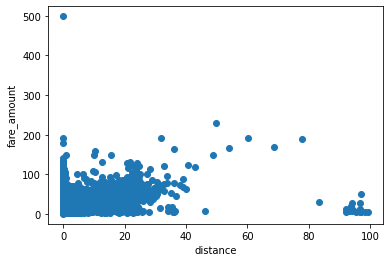

In [56]:
plt.scatter(X_train['distance'], X_train['fare_amount'])
plt.xlabel("distance")
plt.ylabel("fare_amount")
X_train.describe()

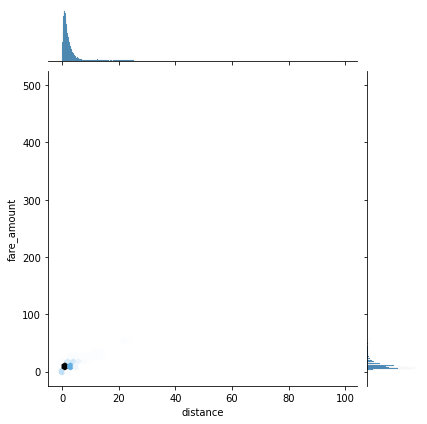

In [57]:
sns.jointplot(data=X_train, x="distance", y="fare_amount", kind="hex")

In [58]:
# Date 
X_train = DateTransformer().transform(X_train)

Date attributes add successfully


0         0.034161
1         0.136032
2         0.213208
3         0.475124
4         0.191473
            ...   
137203    0.106956
137204    0.292773
137205    0.244383
137206    0.123130
137207    0.248647
Name: retio, Length: 137167, dtype: float64

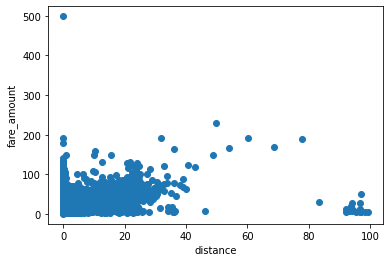

In [59]:
plt.scatter(X_train['distance'], X_train['fare_amount'])
plt.xlabel("distance")
plt.ylabel("fare_amount")
X_train.describe()
X_train.retio

<AxesSubplot:xlabel='retio', ylabel='Count'>

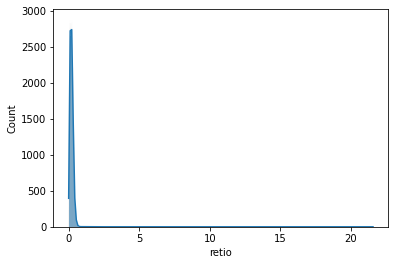

In [60]:
sns.histplot(data=X_train, x="retio", kde=True)

In [61]:
# Retio
train=X_train
retio_tr = RetioTransformer(2)
retio_tr.fit(train)
train = retio_tr.transform(train)
# X_train.describe()

std dev = 0.4074267696794994


Text(0, 0.5, 'fare_amount')

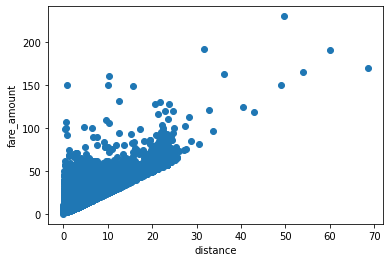

In [62]:
X_train.describe()
plt.scatter(X_train['distance'], X_train['fare_amount'])
plt.xlabel("distance")
plt.ylabel("fare_amount")

<AxesSubplot:xlabel='retio', ylabel='Count'>

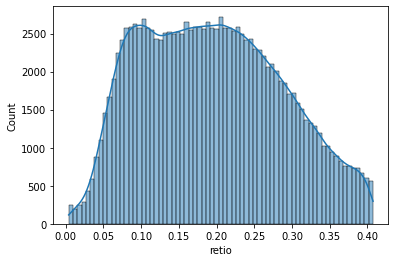

In [63]:
sns.histplot(data=X_train, x="retio", kde=True)

In [64]:
X_train.describe()

,index,Unumber,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,...,hour,weekday,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,retio
count,128126.000000,1.281260e+05,128126.000000,128126.000000,128126.000000,128126.000000,128126.000000,128126.000000,128126.000000,128126.000000,...,128126.000000,128126.000000,128126.000000,128126.000000,128126.000000,128126.000000,128126.000000,128126.000000,128126.000000,128126.000000
mean,99991.937132,2.770874e+07,10.533718,-73.910777,40.687309,-73.910174,40.687527,1.687160,2.235284,2011.776634,...,13.570040,3.043886,0.151148,0.146957,0.157322,0.160381,0.158922,0.153419,0.071851,0.194715
std,57696.406894,1.602162e+07,8.376144,2.729891,2.668965,2.730005,2.669350,1.310268,2.728369,1.864102,...,6.444456,1.938328,0.358195,0.354064,0.364105,0.366961,0.365604,0.360393,0.258242,0.092289
min,1.000000,3.350000e+02,0.110000,-75.387785,-74.015515,-75.417737,-74.009857,0.000000,0.003460,2009.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004086
25%,50086.250000,1.381328e+07,6.000000,-73.992385,40.737068,-73.991864,40.736182,1.000000,0.854494,2010.000000,...,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.118108
50%,100049.500000,2.771552e+07,8.100000,-73.982279,40.753558,-73.981095,40.753975,1.000000,1.498468,2012.000000,...,14.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.189902
75%,149952.750000,4.154488e+07,12.000000,-73.969515,40.767479,-73.967635,40.768387,2.000000,2.597163,2013.000000,...,19.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.263003
max,199999.000000,5.542357e+07,230.000000,40.808425,42.478467,40.831932,42.464187,6.000000,68.496026,2015.000000,...,23.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.407417


# Scatter Plot
**Distance vs Fare Amount**

Text(0, 0.5, 'fare_amount')

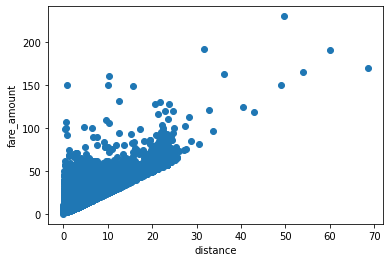

In [65]:
plt.scatter(X_train['distance'], X_train['fare_amount'])
plt.xlabel("distance")
plt.ylabel("fare_amount")


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='year'>

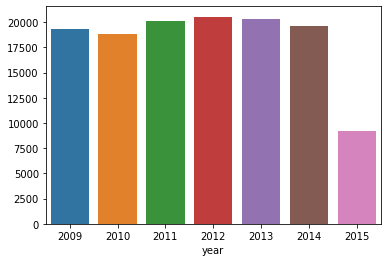

In [66]:
year_uber=X_train.groupby(['year'])['year'].size()
sns.barplot(year_uber.index, year_uber.values)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='month'>

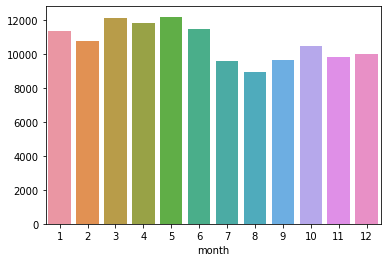

In [67]:
year_uber=X_train.groupby(['month'])['month'].size()
sns.barplot(year_uber.index, year_uber.values)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='weekday'>

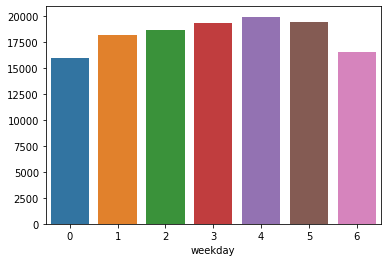

In [68]:
year_uber=X_train.groupby(['weekday'])['weekday'].size()
sns.barplot(year_uber.index, year_uber.values)

<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

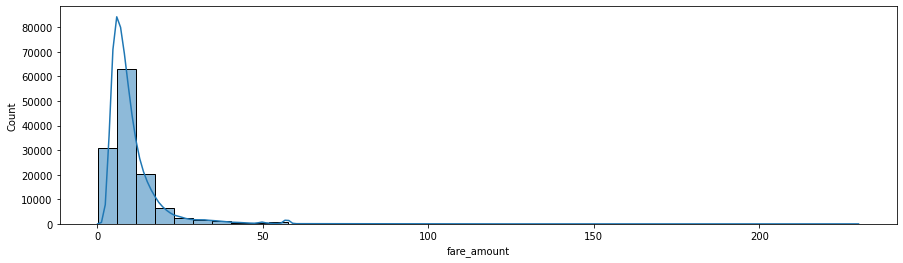

In [69]:
plt.figure(figsize=[15,4])
sns.histplot(data=X_train, x="fare_amount"#, y="distance"
             , bins=40, kde=True)

<AxesSubplot:xlabel='distance', ylabel='Count'>

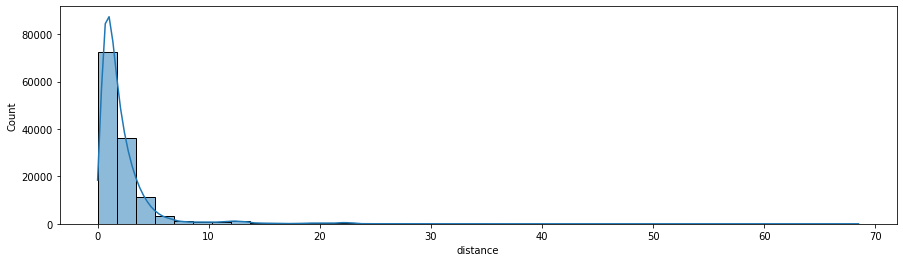

In [70]:
plt.figure(figsize=[15,4])
sns.histplot(data=X_train, x="distance"#, y="distance"
             , bins=40, kde=True)

<AxesSubplot:xlabel='weekday', ylabel='fare_amount'>

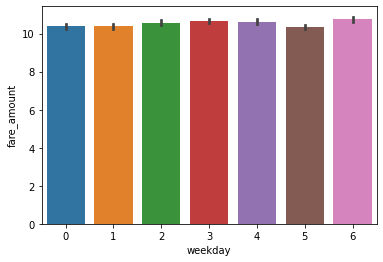

In [71]:
sns.barplot(data=X_train, x="weekday", y="fare_amount")


<AxesSubplot:xlabel='hour', ylabel='fare_amount'>

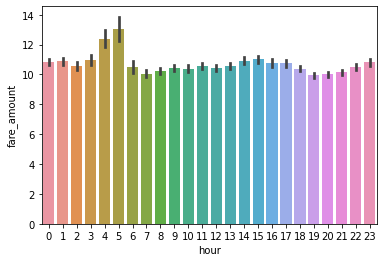

In [72]:
sns.barplot(data=X_train, x="hour", y="fare_amount") 


<AxesSubplot:xlabel='hour', ylabel='distance'>

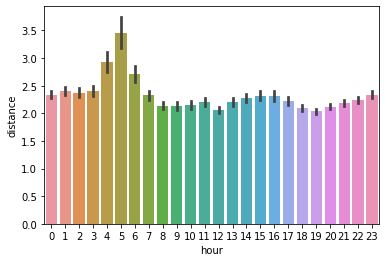

In [73]:
sns.barplot(data=X_train, x="hour", y="distance")

<AxesSubplot:xlabel='weekday', ylabel='distance'>

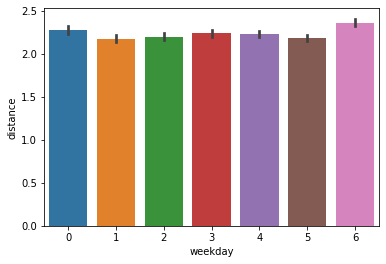

In [74]:
sns.barplot(data=X_train, x="weekday", y="distance")

In [75]:
#plt.figure(figsize=(12,10))
#sns.pairplot(data=X_train)
#plt.show

# Add Dummy

In [76]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128126 entries, 0 to 137207
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   index              128126 non-null  int64              
 1   Unumber            128126 non-null  int64              
 2   key                128126 non-null  object             
 3   fare_amount        128126 non-null  float64            
 4   pickup_datetime    128126 non-null  datetime64[ns, UTC]
 5   pickup_longitude   128126 non-null  float64            
 6   pickup_latitude    128126 non-null  float64            
 7   dropoff_longitude  128126 non-null  float64            
 8   dropoff_latitude   128126 non-null  float64            
 9   passenger_count    128126 non-null  int64              
 10  distance           128126 non-null  float64            
 11  distance_range     128126 non-null  category           
 12  year               128126 non-

In [79]:

# Dummy
X_train = DummyTransformer().transform(X_train)

Get Dummies successfully


# Create function RMSE

In [80]:
def RMSE(y_pred, y_test):
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    print(f"RMSE = {rmse:.2f}")

# Prepare X_test  data 

# X_test 
 

In [81]:

##########################################################
# Clean data where longitude and latitude >90 or <-90 or ==0  
X_test = CleaningTransformer().transform(X_test)

# distance 
X_test = GeoTransformer().transform(X_test)

# date attributes
X_test = DateTransformer().transform(X_test)

# retio
X_test = retio_tr.transform(X_test)

# get dummies 
X_test = DummyTransformer().transform(X_test)
 

X_test.head(10)

Cleaned successfully
Distance attributes add successfully
Date attributes add successfully
Get Dummies successfully


,fare_amount,weekday,distance,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,...,season_1,season_2,weekend_1,weekend_2,distance_range_1,distance_range_2,distance_range_3,distance_range_4,distance_range_8,distance_range_10000
0,60.5,5,13.796400,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
1,5.0,6,0.808590,0,0,0,0,0,0,1,...,1,0,0,1,1,0,0,0,0,0
2,11.3,4,2.613763,0,0,1,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,8.5,5,1.296298,0,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,0,0
4,9.5,6,2.610844,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0
5,15.0,2,3.091198,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,1,0,0
6,12.5,0,2.383886,0,0,0,0,1,0,0,...,0,1,1,0,0,0,1,0,0,0
7,7.3,6,0.869018,1,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
8,7.7,1,0.589024,0,1,0,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0
9,9.5,2,1.011859,0,0,0,1,0,0,0,...,1,0,1,0,0,1,0,0,0,0


# Train test split**

In [82]:
# Train 
y_train=X_train['fare_amount'] # create y varibal to predict
X_train=X_train.drop('fare_amount', axis=1)

# Test
y_test=X_test['fare_amount'] 
X_test=X_test.drop('fare_amount', axis=1)


# Linear Regression

In [83]:
LinearReg = LinearRegression().fit(X_train, y_train)

# Train
y_tr_pred = LinearReg.predict(X_train)
print('TRAIN:')
RMSE(y_tr_pred, y_train)

# Test 
print('TEST:')
y_ts_pred = LinearReg.predict(X_test)
RMSE(y_ts_pred, y_test)

TRAIN:
RMSE = 4.11
TEST:
RMSE = 4.30


# K-Neighbors Regressor

In [ ]:
neighbors = [3,6,10,20,50,99,666]

for neighbor in neighbors:
    print(f'neighbor = {neighbor}')

    Neigh = KNeighborsRegressor(n_neighbors=neighbor)
    Neigh.fit(X_train, y_train)

    # Train
    y_tr_pred = Neigh.predict(X_train)
    print('TRAIN:')
    RMSE(y_tr_pred, y_train)

    # Test 
    print('TEST:')
    y_ts_pred = Neigh.predict(X_test)
    RMSE(y_ts_pred, y_test)
    
    print('-'*50)

neighbor = 3
TRAIN:
RMSE = 3.32
TEST:
RMSE = 4.90
--------------------------------------------------
neighbor = 6
TRAIN:
RMSE = 3.71
TEST:
RMSE = 4.60
--------------------------------------------------
neighbor = 10
TRAIN:
RMSE = 3.88
TEST:
RMSE = 4.49
--------------------------------------------------
neighbor = 20
TRAIN:
RMSE = 4.02
TEST:
RMSE = 4.41
--------------------------------------------------
neighbor = 50
TRAIN:
RMSE = 4.11
TEST:
RMSE = 4.38
--------------------------------------------------
neighbor = 99


# Decision Tree

In [85]:
leafs = [5,10,20,100]
for leaf_number in leafs:
    print(f'leaf number = {leaf_number}')
    Tree = DecisionTreeRegressor(random_state=0, max_leaf_nodes = leaf_number)
    Tree.fit(X_train, y_train)

     # Train
    y_tr_pred = Tree.predict(X_train)
    print('TRAIN:')
    RMSE(y_tr_pred, y_train)

    # Test 
    print('TEST:')
    y_ts_pred = Tree.predict(X_test)
    RMSE(y_ts_pred, y_test)
    print('-'*50)
    

leaf number = 5
TRAIN:
RMSE = 4.66
TEST:
RMSE = 4.87
--------------------------------------------------
leaf number = 10
TRAIN:
RMSE = 4.31
TEST:
RMSE = 4.54
--------------------------------------------------
leaf number = 20
TRAIN:
RMSE = 4.20
TEST:
RMSE = 4.41
--------------------------------------------------
leaf number = 100
TRAIN:
RMSE = 4.02
TEST:
RMSE = 4.42
--------------------------------------------------


In [86]:
features = [5,7,10,15,18 ,22]
for feature in features:
    print(f'feature = {feature}')
    Tree = DecisionTreeRegressor(random_state=0, max_leaf_nodes = 10, max_features = feature)
    Tree.fit(X_train, y_train)

     # Train
    y_tr_pred = Tree.predict(X_train)
    print('TRAIN:')
    RMSE(y_tr_pred, y_train)

    # Test 
    print('TEST:')
    y_ts_pred = Tree.predict(X_test)
    RMSE(y_ts_pred, y_test)
    print('-'*50)

feature = 5
TRAIN:
RMSE = 5.85
TEST:
RMSE = 5.99
--------------------------------------------------
feature = 7
TRAIN:
RMSE = 7.46
TEST:
RMSE = 7.69
--------------------------------------------------
feature = 10
TRAIN:
RMSE = 5.46
TEST:
RMSE = 5.60
--------------------------------------------------
feature = 15
TRAIN:
RMSE = 7.30
TEST:
RMSE = 7.50
--------------------------------------------------
feature = 18
TRAIN:
RMSE = 4.56
TEST:
RMSE = 4.77
--------------------------------------------------
feature = 22
TRAIN:
RMSE = 4.56
TEST:
RMSE = 4.78
--------------------------------------------------
